# Sparse AutoEncoders 
(Main idea is same as simple autoencoder. difference is to add l1 regularization to latent features activations so that some latent features get disabled and their values are close to zero.)

In [1]:
import tensorflow as tf
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
#import tensorflow.compat.v1.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
import matplotlib.pyplot as plt
#import keras_utils
import numpy as np
from tensorflow.keras import regularizers

### Load dataset
Dataset downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [2]:
ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [3]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
#def reset_tf_session():
#    K.clear_session()
#    ops.reset_default_graph()
#    s = K.get_session()
#    return s

In [4]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

In [5]:
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [6]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


18995

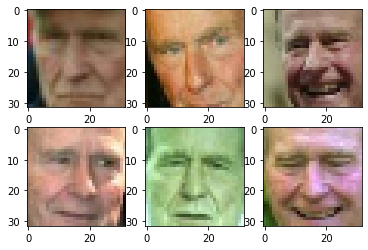

In [7]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train these models.

<img src="autoencoder.png" style="width:50%">

### Build Model with sparseness

In [8]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector

    encoder.add(L.Dense(code_size,
                        activity_regularizer=regularizers.l1(10e-5)))           #actual encoder

    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [9]:
tf.keras.backend.clear_session()

In [10]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=64)

In [11]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [12]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

In [13]:
autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                #callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=1)

Train on 11828 samples, validate on 1315 samples
Epoch 1/15
11828/11828 [==============================] - 2s 170us/sample - loss: 0.0155 - val_loss: 0.0110
Epoch 2/15
11828/11828 [==============================] - 1s 121us/sample - loss: 0.0098 - val_loss: 0.0087
Epoch 3/15
11828/11828 [==============================] - 1s 122us/sample - loss: 0.0081 - val_loss: 0.0075
Epoch 4/15
11828/11828 [==============================] - 1s 123us/sample - loss: 0.0072 - val_loss: 0.0069
Epoch 5/15
11828/11828 [==============================] - 1s 123us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 6/15
11828/11828 [==============================] - 1s 117us/sample - loss: 0.0063 - val_loss: 0.0061
Epoch 7/15
11828/11828 [==============================] - 1s 119us/sample - loss: 0.0061 - val_loss: 0.0060
Epoch 8/15
11828/11828 [==============================] - 1s 127us/sample - loss: 0.0060 - val_loss: 0.0060
Epoch 9/15
11828/11828 [==============================] - 2s 129us/sample - loss: 0.005

In [14]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Sparse AutoEncoders MSE: 0.005569354877470791


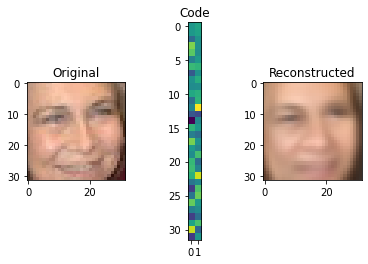

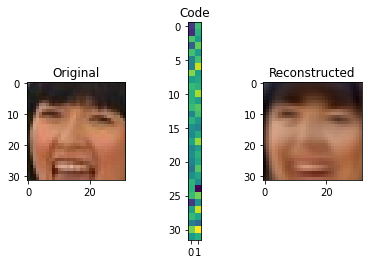

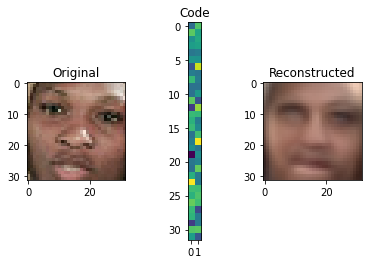

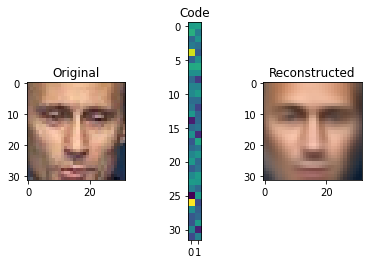

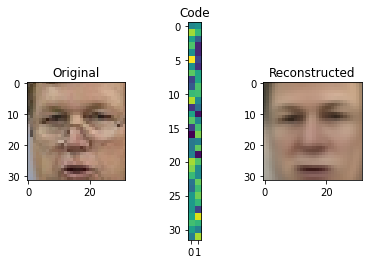

In [15]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Sparse AutoEncoders MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [16]:
code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
code.mean()

-0.022604968

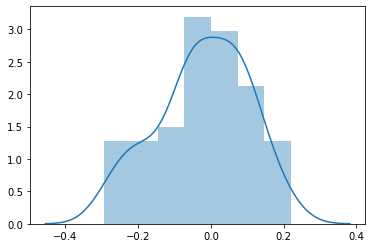

In [17]:
import seaborn as sns
sns.distplot(code)

### Build Model without sparseness

In [18]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector

    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [19]:
tf.keras.backend.clear_session()

In [20]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=64)

In [21]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [22]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

In [23]:
autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                #callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=1)

Train on 11828 samples, validate on 1315 samples
Epoch 1/15
11828/11828 [==============================] - 2s 162us/sample - loss: 0.0129 - val_loss: 0.0088
Epoch 2/15
11828/11828 [==============================] - 1s 119us/sample - loss: 0.0076 - val_loss: 0.0066
Epoch 3/15
11828/11828 [==============================] - 1s 117us/sample - loss: 0.0060 - val_loss: 0.0055
Epoch 4/15
11828/11828 [==============================] - 1s 116us/sample - loss: 0.0052 - val_loss: 0.0050
Epoch 5/15
11828/11828 [==============================] - 1s 113us/sample - loss: 0.0048 - val_loss: 0.0047
Epoch 6/15
11828/11828 [==============================] - 1s 117us/sample - loss: 0.0046 - val_loss: 0.0046
Epoch 7/15
11828/11828 [==============================] - 1s 112us/sample - loss: 0.0046 - val_loss: 0.0045
Epoch 8/15
11828/11828 [==============================] - 1s 111us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 9/15
11828/11828 [==============================] - 1s 122us/sample - loss: 0.004

In [24]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Sparse AutoEncoders MSE: 0.00444800911361472


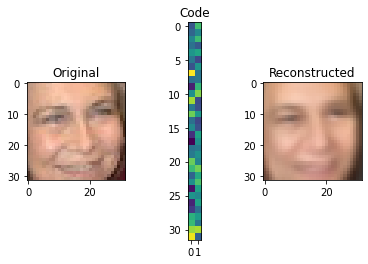

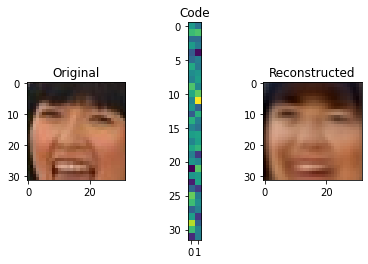

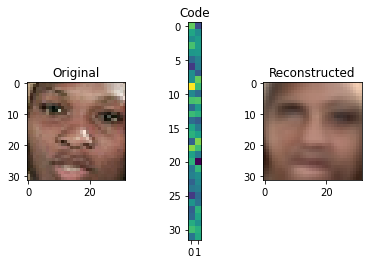

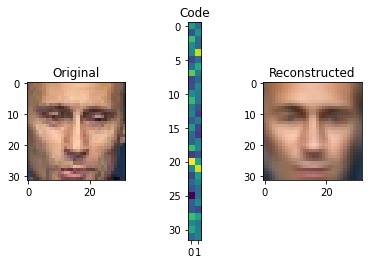

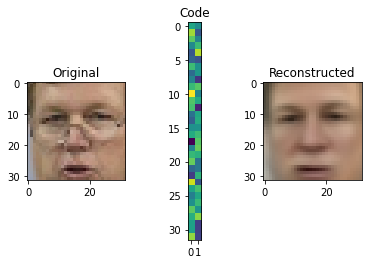

In [25]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Sparse AutoEncoders MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [26]:
code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
code.mean()

0.056050792

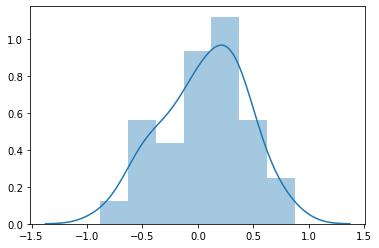

In [27]:
import seaborn as sns
sns.distplot(code)